# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
!pip install termcolor

In [2]:
! pip install tabulate
from tabulate import tabulate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

#import seaborn as sns
#sns.set_style("darkgrid")

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
from termcolor import colored

In [4]:
# get back the used libraries and their versions as a list of tuples
import pkg_resources
import types
def get_imports():
    """ Get a list of packages and versions for README.md
    
        INPUTS: 
        -----------
            None

        OUTPUTS: 
        -----------
            list of tuples with package names and tuples
    """
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
        
imports = list(set(get_imports()))

# Get the versions of the root package
# by cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
printmd('### The additional library requirements to run this notebook')
print(requirements)

### The additional library requirements to run this notebook

[('tabulate', '0.8.7'), ('pandas', '0.23.3'), ('numpy', '1.12.1'), ('matplotlib', '2.1.0')]


In [5]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
printmd('### The head of the main DataFrame df')
df.head()

### The head of the main DataFrame df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
# Show df_content to get an idea of the data
printmd('### The head of the content DataFrame df_content')
df_content.head()

### The head of the content DataFrame df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [7]:
df[df['email']== '0000b6387a0366322d7fbfc6434af145adf7fed1'];

In [8]:
dist = df.groupby('email')['article_id'].value_counts()
dist;

In [9]:
dist = df.groupby('email')['article_id'].count().value_counts()

### Frequency Distribution: Number of article-user interactions

Text(0,0.5,'Frequency')

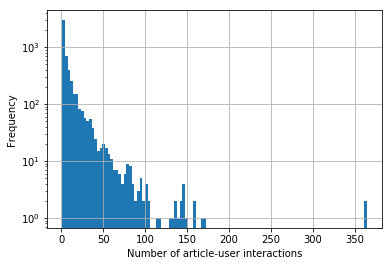

In [10]:
printmd('### Frequency Distribution: Number of article-user interactions')
hist = df.groupby('email')['article_id'].count().hist(bins=len(dist), log=True)
plt.xlabel("Number of article-user interactions")
plt.ylabel("Frequency")

In [11]:
printmd('### Median, mean and mode --> Indication for a right skewed distribution')
print('median = ',df.groupby('email')['article_id'].count().median())
print('mean = ', df.groupby('email')['article_id'].count().mean())
print('mode = ', df.groupby('email')['article_id'].count().mode())

### Median, mean and mode --> Indication for a right skewed distribution

median =  3.0
mean =  8.93084693085
mode =  0    1
dtype: int64


#### Answer to Question 1:
- The distribution of ***how many articles a user interacts with in the dataset*** is quite right skewed (mode < median < mean)
- 50% percent of all user article interactions are less than 3
- There 5148 unique users and 45993 user-article interactions in the dataset
- The number of unique articles is 714

In [12]:
def get_dataframe_summary(df, cat_list, dummy_list, filename='text_for_readme.txt'):
    """ Autogenerate a dataframe summary in addition to the dataframe-describe() function
    
        INPUTS: 
        ----------
            df -  (pandas dataframe) which should be described in an overview
            cat_list - (list) of all categorical input features
            dummy_list - (list) of all dummy input features 

        OUTPUTS:
        ----------
            No direct
            print statements 
            text_for_readme.txt - an auto generated text document with df dataframe summary for the README 
           
    """
    
    number_nan = df.isnull().sum()
    printmd('### DataFrame Overview')
    printmd('- Dataset with {} observations and {} columns'.format(df.shape[0], df.shape[1]))
    
    text_for_readme = '## DataFrame Overview\n'
    text_for_readme += 'Dataset with {} observations and {} columns\n\n'.format(df.shape[0], df.shape[1])
    
    print('___________________________________')
    printmd('- **Numerical** columns:')
    
    text_for_readme += '- **Numerical** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_num = []
    count_int = 0
    count_float = 0
    for col in df.columns.tolist():
        if (df[col].dtypes == 'float64' or df[col].dtypes == 'int64') and col not in cat_list and col not in dummy_list:
            row_num.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col]])
            text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + '\n') 
            if df[col].dtypes == 'int64':
                count_int += 1
            if df[col].dtypes == 'float64':
                count_float += 1
    df_num = pd.DataFrame(row_num,columns=['column_name', 'type', 'min', 'max', 'number NaN'])
    text_for_readme +='\n\n'
    display(df_num)

    print('___________________________________')
    printmd('- **Categorical** columns:')
    
    text_for_readme += '- **Categorical** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_cat = []
    count_object = 0
    for col in df.columns.tolist():
        if df[col].dtypes == 'object' or col in cat_list:
            try:
                row_cat.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col]])
                text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + '\n') 
            except:
                row_cat.append([col, df[col].dtypes, 'NaN', 'NaN', number_nan[col]])
                text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | '+ 'NaN' + ' | '+ 'NaN' + ' | '+ str(number_nan[col]) + ' | ' + '\n') 
            count_object += 1
    df_cat = pd.DataFrame(row_cat,columns=['column_name', 'type', 'min', 'max', 'number NaN'])
    text_for_readme +='\n\n'
    display(df_cat)

    print('___________________________________')
    printmd('- **Dummy** columns:')
    
    text_for_readme += '- **Dummy** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_dummy = []
    for col in dummy_list:
        if (df[col].dtypes == 'float64' or df[col].dtypes == 'int64'):
            row_dummy.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col]])
            text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + '\n')
    df_dummy = pd.DataFrame(row_dummy,columns=['column_name', 'type', 'min', 'max', 'number NaN'])
    text_for_readme +='\n\n'
    display(df_dummy)
    
    print('___________________________________')
    printmd('- There are ***{} numerical*** ({}x int and {}x float) columns'.format(count_int + count_float, count_int, count_float))
    printmd('- There are ***{} categorical*** columns'.format(count_object))
    printmd('- There are ***{} dummy*** columns'.format(len(dummy_list)))
    
    print('___________________________________')
    printmd('- There are ***{} missing values*** in total in the dataset'.format(df.isnull().values.sum()))
    
    
    text_for_readme += '- There are ***{} numerical*** ({}x int and {}x float) columns\n'.format(count_int + count_float, count_int, count_float)
    text_for_readme += '- There are ***{} categorical*** columns\n'.format(count_object)
    text_for_readme += '- There are ***{} dummy*** columns\n'.format(len(dummy_list))
    text_for_readme += '- There are ***{} missing values*** in total in the dataset\n'.format(df.isnull().values.sum())
    
    with open(filename, 'w') as f:
        f.write(text_for_readme)
        

In [13]:
printmd('## DataFrame Summary: df')
printmd('### Descriptive Statistics for df')
display(df.describe(include='all').T)
get_dataframe_summary(df, cat_list=['article_id', 'title', 'email'],dummy_list=[], filename='text_for_readme_df.txt')

## DataFrame Summary: df

### Descriptive Statistics for df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
article_id,45993,NaN,NaN,NaN,908.846,486.648,0,460,1151,1336,1444
title,45993,714,use deep learning for image classification,937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email,45976,5148,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DataFrame Overview

- Dataset with 45993 observations and 3 columns

___________________________________


- **Numerical** columns:

,column_name,type,min,max,number NaN


___________________________________


- **Categorical** columns:

,column_name,type,min,max,number NaN
0,article_id,float64,0,1444,0
1,title,object,0 to life-changing app: new apache systemml ap...,you could be looking at it all wrong,0
2,email,object,NaN,NaN,17


___________________________________


- **Dummy** columns:

,column_name,type,min,max,number NaN


___________________________________


- There are ***0 numerical*** (0x int and 0x float) columns

- There are ***3 categorical*** columns

- There are ***0 dummy*** columns

___________________________________


- There are ***17 missing values*** in total in the dataset

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
printmd('## DataFrame Summary: df_content')
printmd('### Descriptive Statistics for df_content')
display(df_content.describe(include='all').T)
get_dataframe_summary(df_content, cat_list=['doc_body', 'doc_description', 'doc_full_name', 'doc_status', 'article_id'],dummy_list=[],
                     filename='text_for_readme_df_content.txt')

## DataFrame Summary: df_content

### Descriptive Statistics for df_content

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
doc_body,1042,1036,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doc_description,1053,1022,Here’s this week’s news in Data Science and Bi...,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doc_full_name,1056,1051,How smart catalogs can turn the big data flood...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doc_status,1056,1,Live,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_id,1056,NaN,NaN,NaN,523.914,303.481,0,260.75,523.5,786.25,1050


### DataFrame Overview

- Dataset with 1056 observations and 5 columns

___________________________________


- **Numerical** columns:

,column_name,type,min,max,number NaN


___________________________________


- **Categorical** columns:

,column_name,type,min,max,number NaN
0,doc_body,object,NaN,NaN,14
1,doc_description,object,NaN,NaN,3
2,doc_full_name,object,0 to Life-Changing App: New Apache SystemML AP...,“Schemas” in CouchDB,0
3,doc_status,object,Live,Live,0
4,article_id,int64,0,1050,0


___________________________________


- **Dummy** columns:

,column_name,type,min,max,number NaN


___________________________________


- There are ***0 numerical*** (0x int and 0x float) columns

- There are ***5 categorical*** columns

- There are ***0 dummy*** columns

___________________________________


- There are ***17 missing values*** in total in the dataset

In [15]:
# Find and explore duplicate articles
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [16]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby('email')['article_id'].count().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email')['article_id'].count().max()# The maximum number of user-article interactions by any 1 user is ______.

In [18]:
unique_articles =  len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(set(df_content['article_id'].tolist())) # The number of unique articles on the IBM platform
unique_users = len(set(df['email'].dropna().tolist())) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
most_viewed_article_id = str(df.groupby('article_id').count().sort_values(by='email', ascending=False).index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id').count()['email'].max()# The most viewed article in the dataset was viewed how many times?

In [20]:
df.shape

(45993, 3)

In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [22]:
printmd('### Short summary of most important df values:')
print('shape of df: ', df.shape)
print()
print('median = ',df.groupby('email')['article_id'].count().median())
print('mean = ', df.groupby('email')['article_id'].count().mean())
print('mode = ', df.groupby('email')['article_id'].count().mode())
print()
for key, value in sol_1_dict.items():
    print(key.replace('_____',colored(str(value), 'red')).replace('_','').replace('platform', 'platform ' + colored(str(total_articles), 'red')))


### Short summary of most important df values:

shape of df:  (45993, 3)

median =  3.0
mean =  8.93084693085
mode =  0    1
dtype: int64

`50% of individuals have 3.0 or fewer interactions.`
`The total number of user-article interactions in the dataset is 45993.`
`The maximum number of user-article interactions by any 1 user is 364.`
`The most viewed article in the dataset was viewed 937 times.`
`The articleid of the most viewed article is 1429.0.`
`The number of unique articles that have at least 1 rating 714.`
`The number of unique users in the dataset is 5148`
`The number of unique articles on the IBM platform 1051`


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [23]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### Important functions for Rank Based Recommendation

In [24]:
def get_top_articles(n, df=df):
    ''' Create a list of the top 'n' article titles 
    
        INPUTS:
        ------------
            n - (int) the number of top articles to return
            df - (pandas dataframe) df as defined at the top of the notebook 

        OUTPUTS:
        ------------
            top_articles - (list) A list of the top 'n' article titles 
    '''
    # Get a list of the top 'n' article ids
    top_articles_ids = get_top_article_ids(n, df)
    
    # Convert back the string elements in this list to float elements
    top_articles_ids = [float(article_id) for article_id in top_articles_ids]
    
    # Transform those ids to names by using the title column of df
    top_articles = list(df.drop_duplicates(subset=['article_id']).set_index('article_id').loc[top_articles_ids]['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    ''' Create a list of the top 'n' article ids 
    
        INPUTS:
        ------------
            n - (int) the number of top articles to return
            df - (pandas dataframe) df as defined at the top of the notebook 

        OUTPUTS:
        ------------
            top_articles - (list) A list of the top 'n' article ids 
    '''
    # Get the top articles as a list of id float numbers 
    top_articles = list(df.groupby('article_id').count().sort_values(by='user_id', ascending=False).index[0:n])
    
    # Convert the float elements in this list to string elements 
    top_articles = [str(article_id) for article_id in top_articles]
 
    return top_articles # Return the top article ids

In [25]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    ''' Create a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
        an article and a 0 otherwise
    
        INPUTS:
        ------------
            df - pandas dataframe with article_id, title, user_id columns

        OUTPUTS:
        ------------
            user_item - user item matrix 
    '''
    
    # Insert a new column 'interaction' which places 1 in each row 
    df['interaction'] = 1
    
    # Create a user-by-item matrix
    user_item = df.groupby(['user_id', 'article_id'])['interaction'].max().unstack()
    
    # In case of any NaN values isert a 0
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [29]:
printmd('### 10x10 shortcut of the user-item matrix')
display(user_item.iloc[:10,:10])

printmd('#### Shape of user_item: ' + str(user_item.shape))
printmd('#### Example: The number of articles seen by user 1 = ' + str(user_item.sum(axis=1)[1]))

### 10x10 shortcut of the user-item matrix

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0
user_id,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Shape of user_item: (5149, 714)

#### Example: The number of articles seen by user 1 = 36.0

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [30]:
user_id = 2
user_idx = np.where(user_item.index == user_id)[0][0]
user_idx

1

In [31]:
user_item.loc[3];

In [32]:
np.array(user_item.loc[user_id]).reshape(-1,user_item.loc[user_id].shape[0]).shape

(1, 714)

In [33]:
user_1 = np.array(user_item.loc[user_id]).reshape(-1,user_item.loc[user_id].shape[0])

In [34]:
np.transpose(user_item).shape

(714, 5149)

In [35]:
# Take the dot product to obtain a user x user matrix of similarities
dot_prod_users = user_1.dot(np.transpose(user_item))
print(dot_prod_users)

[[ 2.  6.  1. ...,  0.  0.  0.]]


In [36]:
# find the most similar user indices - to start I said they need to be the same for all content
similar_idxs = dot_prod_users.argsort()[-10:][::-1]
similar_idxs
    

array([[2574, 3262, 3261, ...,   48, 3763,    1]])

### Collaborative filtering: Find similar users

In [37]:
from collections import Counter
def find_similar_users(user_id, user_item=user_item, return_sim=False):
    ''' Computes the similarity of every pair of users based on the dot product
    
        INPUTS:
        ------------
            user_id - (int) a user_id
            user_item - (pandas dataframe) matrix of users by articles: 
                        1's when a user has interacted with an article, 0 otherwise

        OUTPUTS:
        ------------
            if return_sim==False:
                most_similar_users - (list) a list of the users in order from most to least similar
            else: 
                df_similarity  - (dataframe), similarity dataframe for actual user with user_id 
                                  col1: neighbour ids
                                  col2: similarities                                   
    '''
    
    # get the row for the actual user_id from user_item matrix in the shape (1,714)
    user_1 = np.atleast_2d(user_item.loc[user_id, :])
    
    # build the dot product of user_1 with the transposed user_item matrix (all users)
    # Matrix multiplication shaping: (1x714) x (714x5149) = (1x5149)
    dot_prod = user_1.dot(np.transpose(user_item))
    
    # construct a dictionary, key = user ids, value = similarity with user_id
    similarity = {}
    for i in range(1, user_item.shape[0]+1):
        similarity[i] = dot_prod[0][i-1]
    
    # sort this dicctionary with descending similarity
    c = Counter(similarity)
    similarity_ordered = c.most_common()
    
    # get list of neighbourhood users
    neighbours = [item[0] for item in  similarity_ordered]
    
    
    if return_sim == False:
        # remove actual user with user_id from most_similar_users
        neighbours.remove(user_id)
        most_similar_users = neighbours
        
        return most_similar_users # return a list of the users in order from most to least similar
    
    else:
        # get list of neighbourhood similarities 
        similarities = [item[1] for item in  similarity_ordered]
        df_similarity = pd.DataFrame({'neighbour_id': neighbours, 'similarity': similarities})
        return df_similarity
        

In [38]:
# Do a spot check of your function
printmd('### Short Test of find_similar_users(...) function')
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

### Short Test of find_similar_users(...) function

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [39]:
df.head()

,article_id,title,user_id,interaction
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [40]:
df[df['user_id']== 2]['article_id'].tolist()

[1314.0, 1305.0, 1024.0, 1176.0, 1422.0, 1427.0]

In [41]:
user_item.loc[3][user_item.loc[3] !=0].index.tolist();

In [42]:
len(df_content)

1051

In [43]:
article_ids= [0,1,2,3,4]

In [44]:
df_content[df_content['article_id'].isin(article_ids)]['doc_full_name'].tolist()

['Detect Malfunctioning IoT Sensors with Streaming Analytics',
 'Communicating data science: A guide to presenting your work',
 'This Week in Data Science (April 18, 2017)',
 'DataLayer Conference: Boost the performance of your distributed database',
 'Analyze NY Restaurant data using Spark in DSX']

### Collaborative Filtering: Make Recommendations - Approach 1

In [45]:
def get_article_names(article_ids, df=df):
    ''' Provide a list of article names associated with the list of article ids
    
        INPUTS:
        ------------
            article_ids - (list) a list of article ids
            df - (pandas dataframe) df as defined at the top of the notebook

        OUTPUTS:
        ------------
            article_names - (list) a list of article names associated with the list of article ids 
                            (this is identified by the title column)
    '''
    # A list of article names associated with the list of article ids 
    article_names = list(set(list(df[df['article_id'].astype(str).isin(article_ids)]['title'])))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    ''' Provide a list of article ids and names associated with the list of article ids
        INPUTS:
        ------------
            user_id - (int) a user id
            user_item - (pandas dataframe) matrix of users by articles: 
                        1's when a user has interacted with an article, 0 otherwise

        OUTPUTS:
        ------------
            article_ids - (list) a list of the article ids seen by the user
            article_names - (list) a list of article names associated with the list of article ids 
                            (this is identified by the doc_full_name column in df_content)

            Description:
            Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get a list of the article ids seen by the user. Provide each element of this list as a string value 
    article_ids = user_item.loc[user_id][user_item.loc[user_id] != 0].index.astype(str).tolist()
    
    # By using thgis list of ids get the names of the articles (list)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
        INPUTS:
        ------------
            user_id - (int) a user id
            m - (int) the number of recommendations you want for the user

        OUTPUTS:
        ------------
            recs - (list) a list of recommendations for the user

            Description:
            Loops through the users based on closeness to the input user_id
            For each user - finds articles the user hasn't seen before and provides them as recs
            Does this until m recommendations are found

            Notes:
            Users who are the same closeness are chosen arbitrarily as the 'next' user

            For the user where the number of recommended articles starts below m 
            and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # articles_seen by user (we don't want to recommend these)
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    closest_neighbors = find_similar_users(user_id)
    
    # Keep the recommended articles here
    recs = np.array([])
    
    # Go through the neighbors and identify articles they like the user hasn't seen
    for neighbor in closest_neighbors:
        # get article ids and names as lists (of neighbours)
        neighbs_likes_ids, neighbs_likes_names  = get_user_articles(neighbor)
        
        # Obtain recommendations for the actual neighbor
        new_recs = np.setdiff1d(neighbs_likes_ids, articles_seen_ids, assume_unique=True)
    
        # Update recs with new recs
        recs = np.concatenate([recs, new_recs], axis=0)
        
        # Keep unique elements after concatenation
        _, idx = np.unique(recs, return_index=True)
        
        # Keep order (first neighbour is the most similar - so prefer his suggestions)
        recs = recs[np.sort(idx)]
        
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    
    recs = recs[:10]
    #print(list(recs))
    # Pull article titles using article ids
    recommendations = list(recs)
    

    return recommendations # return your recommendations for this user_id    

In [46]:
# Check Results
printmd('### Short Test of Collaborative Filtering Part 1 - Make 10 article recommendations for user with user_id=20')
get_article_names(user_user_recs(20, 10))

### Short Test of Collaborative Filtering Part 1 - Make 10 article recommendations for user with user_id=20

['learn tensorflow and deep learning together and now!',
 'modeling energy usage in new york city',
 'deep learning with tensorflow course by big data university',
 'tidy up your jupyter notebooks with scripts',
 'generalization in deep learning',
 'what is machine learning?',
 'a visual explanation of the back propagation algorithm for neural networks',
 'tensorflow quick tips',
 'data structures related to machine learning algorithms',
 'building custom machine learning algorithms with apache systemml']

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
find_similar_users(2, user_item=user_item, return_sim=True);

In [49]:
num_interactions = df.groupby('user_id')['article_id'].count()
num_interactions

num_interactions_df = pd.DataFrame(list(num_interactions), columns=['num_interactions'], index= num_interactions.index)
num_interactions_df;

In [50]:
num_interactions_df;

In [51]:
num_interactions_df[num_interactions_df.index==2]['num_interactions'].values[0]


6

In [52]:
neighbors_df = find_similar_users(2, user_item=user_item, return_sim=True)
neighbors_df['num_interactions'] = neighbors_df['neighbour_id'].apply(lambda x: num_interactions_df[num_interactions_df.index==x]['num_interactions'].values[0])
neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
neighbors_df = neighbors_df[1:]
neighbors_df.head(20);

### Collaborative Filtering: Make Recommendations - Optimized approach
Generate a sorted DataFrame ***neighbors_df*** to relate a user based on his user_id with similar neighbours. Similarity sorting is done via:
- Sort the neighbors_df by the similarity and then by number of interactions.
- Cols in the dataframe are_
    - ***neighbor_ids***
    - corresponding ***similarity*** of this neighbour with the user and 
    - ***num_interactions*** - the number of neighbour-article-interactions

In [53]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    ''' Generate a DataFrame for the actual user with his neighbor_ids, corresponding similarities 
        and the number of neighbour-article-interactions 
    
        INPUTS:
        ------------
            user_id - (int)
            df - (pandas dataframe) df as defined at the top of the notebook 
            user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise


        OUTPUTS:
        ------------
            neighbors_df - (pandas dataframe) a dataframe with:
                            neighbor_id - is a neighbor user_id
                            similarity - measure of the similarity of each user to the provided user_id
                            num_interactions - the number of articles viewed by the user - if a u

            Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                            highest of each is higher in the dataframe
     
    '''
    # Construct the neighbours dataframe by using find_similar_users and 
    # set return_sim to True --> to get back a 'similar neighbour dataframe' 
    neighbors_df = find_similar_users(user_id, user_item=user_item, return_sim=True)
    
    # Calculate the number of each neighbour by using a lambda function approach
    neighbors_df['num_interactions'] = neighbors_df['neighbour_id'].apply(lambda x: num_interactions_df[num_interactions_df.index==x]['num_interactions'].values[0])
    
    # Sort this dataframe first by the col 'similarity' and second by the col 'num_interactions'
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    # Remove the actual user with user_id from that dataframe
    neighbors_df = neighbors_df[neighbors_df['neighbour_id'] != user_id]
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, top_most=True):
    '''
        INPUTS:
        ------------
            user_id - (int) a user id
            m - (int) the number of recommendations you want for the user
            top_most - (bool) if True --> keep for the (numpy array) new_recs 
                        only the intersection with the top_articles numpy array

        OUTPUTS:
        ------------
            recs - (list) a list of recommendations for the user by article id
            rec_names - (list) a list of recommendations for the user by article title

            Description:
            Loops through the users based on closeness to the input user_id
            For each user - finds articles the user hasn't seen before and provides them as recs
            Does this until m recommendations are found

            Notes:
            * Choose the users that have the most total article interactions 
            before choosing those with fewer article interactions.

            * Choose articles with the articles with the most total interactions 
            before choosing those with fewer total interactions. 
   
    '''
    
    # articles_seen by user (we don't want to recommend these)
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    
    # Get the neighbours stored in the neighbors_df dataframe
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get the neighbours as list of ids
    closest_neighbors = neighbors_df['neighbour_id'].tolist()
    
    # Get the top 100 articles as a list of ids
    top_articles = get_top_article_ids(100)
    
    #print('top_articles')
    #print(top_articles)
    
    # Keep the recommended articles here
    recs = np.array([])
    
    # Go through the neighbors and identify articles they like the user hasn't seen
    for neighbor in closest_neighbors:
        
        # get article ids and names as lists (of neighbours)
        neighbs_likes_ids, neighbs_likes_names  = get_user_articles(neighbor)
        
        # Obtain recommendations for the actual neighbor
        new_recs = np.setdiff1d(neighbs_likes_ids, articles_seen_ids, assume_unique=True)
        
        if top_most == True:
            # keep only articles of this neighbour which are in th top 100 article list
            new_recs = np.intersect1d(new_recs, top_articles)
        
        # Update recs with new recs
        recs = np.concatenate([recs, new_recs], axis=0)
        
        # Keep unique elements after concatenation
        _, idx = np.unique(recs, return_index=True)
        
        # Keep order (first neighbour is the most similar - so prefer his suggestions)
        recs = recs[np.sort(idx)]
        
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    
    # Pull article titles using article ids, keep only m ones
    rec_ids= list(recs)[:m]
    
    # Transform those ids to article names
    rec_names = get_article_names(rec_ids)

    return rec_ids, rec_names  # return your recommendations for this user_id    


In [54]:
user_id = 1
printmd('### Short check of first neighbors_df for the user with user_id = ' + str(user_id))
get_top_sorted_users(user_id).head(10)

### Short check of first neighbors_df for the user with user_id = 1

,neighbour_id,similarity,num_interactions
1,3933,35.0,45
2,23,17.0,364
3,3782,17.0,363
4,203,15.0,160
5,4459,15.0,158
6,131,14.0,145
7,3870,14.0,144
8,46,13.0,63
9,4201,13.0,61
10,49,12.0,147


In [55]:
# print(tabulate(get_top_sorted_users(user_id).head(10), tablefmt="pipe", headers="keys"))

In [56]:
# Quick spot check - don't change this code - just use it to test your functions
printmd('### Short Test of Collaborative Filtering Part 2 - Make 10 article recommendations for user with user_id=20')
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

### Short Test of Collaborative Filtering Part 2 - Make 10 article recommendations for user with user_id=20

The top 10 recommendations for user 20 are the following article ids:
['109.0', '1160.0', '1162.0', '1163.0', '1166.0', '1170.0', '1172.0', '1176.0', '12.0', '125.0']

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'analyze open data sets with spark & pixiedust', 'apache spark lab, part 3: machine learning', 'apache spark lab, part 1: basic concepts', 'build a python app on the streaming analytics service', 'statistics for hackers', 'analyzing data by using the sparkling.data library features', 'tensorflow quick tips', 'timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings']


In [57]:
user_id = 100
printmd('#### user_id = ' + str(user_id))
printmd('### Compare Collaborative Recommendation System 1 with optimized System 2 for user_id = ' + str(user_id))
df_compare_recs = pd.DataFrame({'Collaborative Recommendation Part 1': list(get_article_names(user_user_recs(user_id, 10))), 
              'Collaborative Recommendation Part 2': list(user_user_recs_part2(user_id, 10)[1])
             })

display(df_compare_recs)

printmd('### Which of the top most recommendations are common in both colab. recommendation approaches?')
common = list(np.intersect1d(df_compare_recs['Collaborative Recommendation Part 1'], df_compare_recs['Collaborative Recommendation Part 2']))  

printmd('#### Common articles:')
print('\n'.join(common))
    

#### user_id = 100

### Compare Collaborative Recommendation System 1 with optimized System 2 for user_id = 100

,Collaborative Recommendation Part 1,Collaborative Recommendation Part 2
0,learn tensorflow and deep learning together an...,breast cancer wisconsin (diagnostic) data set
1,jupyter notebook tutorial,analyze accident reports on amazon emr spark
2,how to scale your analytics using r,categorize urban density
3,practical tutorial on random forest and parame...,analyze open data sets with spark & pixiedust
4,"this week in data science (february 7, 2017)",access db2 warehouse on cloud and db2 with python
5,data science bowl 2017,practical tutorial on random forest and parame...
6,a dynamic duo – inside machine learning – medium,data tidying in data science experience
7,apache spark™ 2.0: extend structured streaming...,a dynamic duo – inside machine learning – medium
8,timeseries data analysis of iot events by usin...,analyzing data by using the sparkling.data lib...
9,python machine learning: scikit-learn tutorial,timeseries data analysis of iot events by usin...


### Which of the top most recommendations are common in both colab. recommendation approaches?

#### Common articles:

a dynamic duo – inside machine learning – medium
practical tutorial on random forest and parameter tuning in r
timeseries data analysis of iot events by using jupyter notebook


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [58]:
def get_nth_closest_neighbour(user_id, n):
    """ Find the nth most similar user to user with user_id
        
        INPUTS:
        ------------
            user_id - (int) the id number of the actual user for investigation  
            n - (int) the nth most similar neighbour
            
        OUTPUTS:
        ------------
            user_nth_most_sim - (int) the neighbour id of the nth most similar user
    """
    neighbors_df = get_top_sorted_users(user_id)
    user_nth_most_sim = int(neighbors_df.iloc[n-1]['neighbour_id'])
    return user_nth_most_sim

print('The user that is most similar to user 1: ', get_nth_closest_neighbour(1, 1))
print('The 10th most similar to user 131: ', get_nth_closest_neighbour(131, 10))

The user that is most similar to user 1:  3933
The 10th most similar to user 131:  242


In [59]:
### Tests with a dictionary of results
user1_most_sim = get_nth_closest_neighbour(1, 1) # Find the user that is most similar to user 1 
user131_10th_sim = get_nth_closest_neighbour(131, 10) # Find the 10th most similar user to user 131

In [60]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user we do not have any preferences in the beginning. Due to this ***Cold Start problem*** we should provide the ***'top most seen'*** articles to this new user.
In this case of new users I would use

- ***Rank-based recommendation***: I would use the functions ***get_top_articles(n, df=df)*** (in combination with ***get_top_article_ids(n, df=df)***)



In addition, we could use: 
- ***Knowledge Based recommendation***. We could provide a seach mask where the user could enter key words. With those key words we could search appropriate recommendations in the database 

- When the user enters the web page we could ***ask the user to select his interests*** from a list of interests

- We could try to use ***cookies*** to expore the users preferences

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [61]:
new_user = '0.0'
# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df=df) # Your recommendations here
new_user_recs_names = get_top_articles(10, df=df)
printmd('### The top 10 articles we should provide to new users (Cold Start Problem)')
print('\n'.join(new_user_recs_names))

### The top 10 articles we should provide to new users (Cold Start Problem)

use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm
healthcare python streaming application demo
finding optimal locations of new store using decision optimization
apache spark lab, part 1: basic concepts
analyze energy consumption in buildings
gosales transactions for logistic regression model


In [62]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [63]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [64]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [65]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [66]:
printmd('### 10x10 shortcut of the user-item matrix')
display(user_item_matrix.iloc[:10,:10])

printmd('#### Shape of user_item: ' + str(user_item_matrix.shape))
printmd('#### Example: The number of articles seen by user 1 = ' + str(user_item_matrix.sum(axis=1)[1]))

### 10x10 shortcut of the user-item matrix

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0
user_id,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Shape of user_item: (5149, 714)

#### Example: The number of articles seen by user 1 = 36.0

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [67]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

- We can use Traditional-SVD istead of FunkSVD as we do not have any NaN values.
- We do not use (continuous or distinct number) ratings of articles. Instead we use 0s and 1s dummies. 
- no user-item-interaction --> 0 
- user-item-interaction observed --> 1
- In case a user has not yet read an article there will be a 0 and not a NaN in the corresponding cell of the user_item matrix.
- However, we could still use FunkSVD with randomized 0s and 1s for the u and vt matrices in the beginning. Then we could get the correct (optimized) '0s' and '1s' during training.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

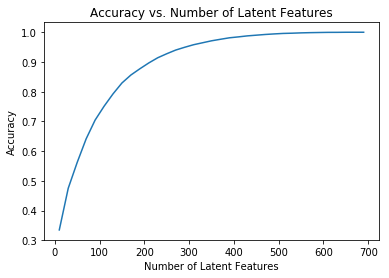

In [68]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [69]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
        INPUTS:
        -----------
            df_train - training dataframe
            df_test - test dataframe

        OUTPUTS:
        ------------
            user_item_train - a user-item matrix of the training dataframe 
                              (unique users for each row and unique articles for each column)
            user_item_test - a user-item matrix of the testing dataframe 
                            (unique users for each row and unique articles for each column)
            test_idx - all of the test user ids
            test_arts - all of the test article ids
    
    '''
    # Get user_item_train from create_user_item_matrix(df)
    user_item_train = create_user_item_matrix(df_train)
    
    # Get user_item_test from create_user_item_matrix(df)
    user_item_test = create_user_item_matrix(df_test)
    
    # test rows (train user_ids) and colums (test articles) of user_item_test meatrix
    test_idx = user_item_test.index 
    test_arts = user_item_test.columns 
    
    # train rows (train user_ids) and colums (train articles) of user_item_train meatrix
    train_idx = user_item_train.index 
    train_arts = user_item_train.columns 
    
    # common rows and columns between train and test matrix
    common_rows = train_idx.intersection(test_idx)
    common_cols = train_arts.intersection(test_arts)
    
    
    # user_item_test based on common rows and columns
    user_item_test = user_item_test.loc[common_rows, common_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts, common_rows, common_cols

user_item_train, user_item_test, test_idx, test_arts, common_rows, common_cols = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [70]:
# Shape of user_item_train
user_item_train.shape

(4487, 714)

In [71]:
# Shape of user_item_test
user_item_test.shape

(20, 574)

In [72]:
# Number of rows (user_ids) in user_item_test
len(test_idx)

682

In [73]:
# Number of commmon indices in user_item_train and user_item_test
number_of_pos_preds_user = user_item_train.index.isin(test_idx).sum()
number_of_pos_preds_user

20

In [74]:
# Number of users we can can make predictions for in the test set
number_of_non_preds_user = len(test_idx) - number_of_pos_preds_user
number_of_non_preds_user

662

In [75]:
# How many articles can we make predictions for in the test set?
number_of_pos_preds_articles = user_item_train.columns.isin(test_arts).sum()
number_of_pos_preds_articles

574

In [76]:
number_of_no_preds_articles = len(test_arts) - number_of_pos_preds_articles
number_of_no_preds_articles

0

In [77]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [78]:
printmd('### Short summary for the train and test split:')
print('shape of user_item_train: ', user_item_train.shape)
print('shape of user_item_test: ', user_item_test.shape)
print()
print('How many users can we make predictions for in the test set? ', number_of_pos_preds_user)
print('How many users in the test set are we not able to make predictions for because of the cold start problem? ', number_of_non_preds_user)
print('How many articles can we make predictions for in the test set? ', number_of_pos_preds_articles)
print('How many movies in the test set are we not able to make predictions for because of the cold start problem? ', number_of_no_preds_articles)


### Short summary for the train and test split:

shape of user_item_train:  (4487, 714)
shape of user_item_test:  (20, 574)

How many users can we make predictions for in the test set?  20
How many users in the test set are we not able to make predictions for because of the cold start problem?  662
How many articles can we make predictions for in the test set?  574
How many movies in the test set are we not able to make predictions for because of the cold start problem?  0


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [79]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [80]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [81]:
row_idxs = user_item_train.index.isin(test_idx)
row_idxs

array([False, False, False, ..., False, False,  True], dtype=bool)

In [82]:
common_rows

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
            3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487],
           dtype='int64', name='user_id')

In [145]:
!pip install scikit-learn==0.20
num_latent_feats = np.arange(1,700,10)
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

df_preds_train = pd.DataFrame(columns=['f1-score', 'precision', 'recall', 'support', 'accuracy'])

df_preds_test = pd.DataFrame(columns=['f1-score', 'precision', 'recall', 'support', 'accuracy'])

for k in num_latent_feats:
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # Dot product:
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
   
    # Calculate the error of each prediction with the true value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # Total Error
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    

    # Flatten user_item_train matrix (=label) to 1d array for classification report 
    labels_train_flat = user_item_train.values.flatten()
    # Flatten user_item_test matrix (=label) to 1d array for classification report 
    labels_test_flat = user_item_test.values.flatten()
    # Flatten user_item_train_preds  matrix to 1d array for classification report
    train_preds_flat = user_item_train_preds.flatten()
    # Flatten user_item_test_preds matrix to 1d array for classification report 
    test_preds_flat = user_item_test_preds.flatten()
    
    
    # Train
    accuracy_train = 1 - np.array(err_train)/(user_item_train.shape[0]*user_item_train.shape[1])
    class_rep_train = pd.DataFrame(classification_report(labels_train_flat, train_preds_flat, output_dict=True)).T.iloc[-1,:]
    class_rep_train = pd.DataFrame(class_rep_train).T
    class_rep_train.index = [k]
    class_rep_train['accuracy'] = accuracy_train                        
    df_preds_train = pd.concat([df_preds_train, class_rep_train])
    

    # Test
    accuracy_test = 1 - np.array(err_test)/(user_item_test.shape[0]*user_item_test.shape[1])
    class_rep_test = pd.DataFrame(classification_report(labels_test_flat, test_preds_flat, output_dict=True)).T.iloc[-1,:]
    class_rep_test = pd.DataFrame(class_rep_test).T
    class_rep_test.index = [k]
    class_rep_test['accuracy'] = accuracy_test                        
    df_preds_test = pd.concat([df_preds_test, class_rep_test])
    
   
    
df_preds_train = df_preds_train.drop('support', axis=1)
df_preds_train.columns = ['Train-f1-score', 'Train-precision', 'Train-recall', 'Train-accuracy']
df_preds_test = df_preds_test.drop('support', axis=1)
df_preds_test.columns = ['Test-f1-score', 'Test-precision', 'Test-recall', 'Test-accuracy']

display(df_preds_train)
display(df_preds_test)
    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Train-f1-score,Train-precision,Train-recall,Train-accuracy
1,0.986799,0.988153,0.990977,0.990977
11,0.988841,0.990970,0.991854,0.991854
21,0.990572,0.992434,0.992768,0.992768
31,0.991881,0.993419,0.993542,0.993542
41,0.992770,0.994083,0.994115,0.994115
51,0.993585,0.994646,0.994656,0.994656
61,0.994314,0.995168,0.995166,0.995166
71,0.994955,0.995641,0.995631,0.995631
81,0.995494,0.996048,0.996035,0.996035
91,0.995963,0.996412,0.996400,0.996400


,Test-f1-score,Test-precision,Test-recall,Test-accuracy
1,0.971476,0.962377,0.980749,0.980749
11,0.971657,0.966880,0.978310,0.978310
21,0.971438,0.966964,0.977265,0.977265
31,0.972028,0.968424,0.976742,0.976742
41,0.971509,0.967975,0.975871,0.975871
51,0.971096,0.967673,0.975174,0.975174
61,0.970534,0.967321,0.974216,0.974216
71,0.970324,0.967336,0.973693,0.973693
81,0.969846,0.967363,0.972561,0.972561
91,0.969592,0.967251,0.972125,0.972125


Text(0,0.5,'Metric value')

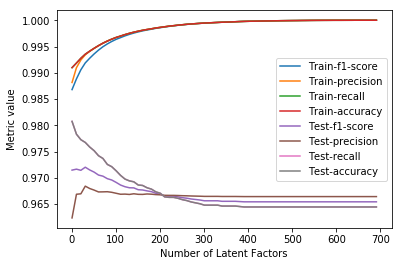

In [161]:
# Plot Metrics
ax = df_preds_train.plot()
df_preds_test.plot(ax=ax)
ax.set_xlabel("Number of Latent Factors")
ax.set_ylabel("Metric value")

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

- With an increasing number of latent features one observes an increasing Training accuracy but a decreasing Test accuracy. 
- From only checking accuracy one could argue that there seems to be overfitting by using the SVD technique.
- However, by checking other metrics like precision, recall and f1-score (= harmonic mean of precision and recall) one observes a stagnation effect at around 0.965 (for all three metrics). This indicates that an increase of k does not give any new information.
- With regard to precision there is even a slight enhancement for an increasing the k value up to 20. This is also the region where f1-score does not seems to deacrease. Precision means here: the ratio of the correct positive predictions (number of correct predictions "user iteracted with article", or correct predicted "1's" in the user-item-matrix) to the total number of positive predictions (number of correct and incorrect predictions that a "user interacted with an article").
- Hence, I would use k values of up to 20 in maximum (interestingly, this is also in the range of users we could make predictions for)   
- For sure it does not make sense to increase the number of latent features larger than that as other test metrics are getting worse. The number of users in the test set (20) for which we could make predictions for is too low for a high latent factor space. This would only increase the noise in making predictions. In order to decrease this noise more data (more users) would be needed for the test set. 
- Due to this 'low-amount-of-test-user' problem I would not use SVD alone at the moment.
- I would use techniques as proposed under III.6 in addition.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])